# PARTIE 1 : Analyse exploratoire des données

## Import librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Lecture des données

In [2]:
data = pd.read_csv('./src/rentals_data.csv', sep=';')

In [3]:
print(data.shape)
data.isna().sum()/data.shape[0]*100

(21310, 7)


rental_id                                      0.000000
car_id                                         0.000000
checkin_type                                   0.000000
state                                          0.000000
delay_at_checkout_in_minutes                  23.294228
previous_ended_rental_id                      91.360863
time_delta_with_previous_rental_in_minutes    91.360863
dtype: float64

In [4]:
data.count()/len(data.index)

rental_id                                     1.000000
car_id                                        1.000000
checkin_type                                  1.000000
state                                         1.000000
delay_at_checkout_in_minutes                  0.767058
previous_ended_rental_id                      0.086391
time_delta_with_previous_rental_in_minutes    0.086391
dtype: float64

## Valeurs erronnées

In [5]:
data.drop([21002], axis=0, inplace=True)

In [6]:
data.rename(columns={'delay_at_checkout_in_minutes': 'delay', 
                     'previous_ended_rental_id': 'previous_id', 
                     'time_delta_with_previous_rental_in_minutes': 'time_gap'}, 
                      inplace = True)

In [7]:
df = data.copy()
df = df.fillna(0)

In [8]:
df['canceled'] = df['state'].apply(lambda x: 1 if x == 'canceled' else 0)
df['delayed'] = df['delay'].apply(lambda x: 1 if x > 0 else 0)
df['previous'] = df['previous_id'].apply(lambda x: 1 if x != 0 else 0)
df['previous_id'] = df['previous_id'].astype(int)

In [9]:
df.dtypes

rental_id         int64
car_id            int64
checkin_type     object
state            object
delay           float64
previous_id       int64
time_gap        float64
canceled          int64
delayed           int64
previous          int64
dtype: object

In [10]:
df.to_csv('./src/rentals_data_clean.csv', index=False)

## Statistiques basiques

In [9]:
df = pd.read_csv('./src/rentals_data_clean.csv')

In [10]:
df.describe(include='all')

,rental_id,car_id,checkin_type,state,delay,previous_id,time_gap,canceled,delayed,previous
count,21309.000000,21309.000000,21309,21309,21309.000000,21309.000000,21309.000000,21309.000000,21309.000000,21309.000000
unique,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,mobile,ended,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,17002,18045,NaN,NaN,NaN,NaN,NaN,NaN
mean,549712.438594,350029.218405,NaN,NaN,46.616406,47528.488667,24.129241,0.153175,0.441316,0.086395
std,13863.622290,58207.264418,NaN,NaN,870.206204,154608.854714,108.417324,0.360164,0.496556,0.280954
min,504806.000000,159250.000000,NaN,NaN,-22433.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,540613.000000,317639.000000,NaN,NaN,-16.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,550349.000000,368710.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,560469.000000,394928.000000,NaN,NaN,41.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [11]:
print('Total parc voitures :', df['car_id'].nunique())
print()
print('Total locations :', df['rental_id'].nunique())
print('- dont mobile :', len(df[df['checkin_type']=='mobile']),'soit', round(len(df[df['checkin_type']=='mobile'])/df['checkin_type'].count()*100,2), '%')
print('- dont connect :', len(df[df['checkin_type']=='connect']), 'soit', round(len(df[df['checkin_type']=='connect'])/df['checkin_type'].count()*100,2), '%')
print()
print('Total annulations :', df['canceled'].sum(), 'soit', round(df['canceled'].sum()/df['canceled'].count()*100,2), '%')
print()
print('Total locations serrées :', df['previous'].sum(), 'soit', round(df['previous'].sum()/df['previous'].count()*100,2), '%')
print()
print('Total retards :', df['delayed'].sum(), 'soit', round(df['delayed'].sum()/df['delayed'].count()*100,2), '%')
print('Retard moyen :', round(df[df['delayed']==1]['delay'].mean()), 'minutes soit', round(df[df['delayed']==1]['delay'].mean()))
print('Délai de retour moyen:', round(df['delay'].mean()), 'minutes')

Total parc voitures : 8142

Total locations : 21309
- dont mobile : 17002 soit 79.79 %
- dont connect : 4307 soit 20.21 %

Total annulations : 3264 soit 15.32 %

Total locations serrées : 1841 soit 8.64 %

Total retards : 9404 soit 44.13 %
Retard moyen : 202 minutes soit 202
Délai de retour moyen: 47 minutes


## Analyse des locations serrées

Tout d'abord nous définissons 2 termes : 

- **tight_rentals** (locations serrées) : ce sont les locations qui succèdent une location dans un délai inférieur à 12h (previous=1).

- **before_tight_rentals**  : ce sont les locations qui précèdent une location serrée.


In [12]:
tight_rentals = df[(df['previous'] == 1)]
tight_rentals_canceled = tight_rentals[tight_rentals['canceled'] == 1]
tight_rentals_ended = tight_rentals[tight_rentals['canceled'] == 0]

In [13]:
df_temp = df[['rental_id', 'delay']]
df_temp = df_temp.rename(columns={'delay': 'previous_delay'})

In [14]:
tight_rentals_enriched = pd.merge(tight_rentals, df_temp, left_on='previous_id', right_on='rental_id') 
tight_rentals_enriched.drop(['rental_id_y'], axis=1, inplace=True)
tight_rentals_enriched.rename(columns={'rental_id_x':'rental_id'}, inplace=True)
tight_rentals_enriched

,rental_id,car_id,checkin_type,state,delay,previous_id,time_gap,canceled,delayed,previous,previous_delay
0,511639,370585,connect,ended,-15.0,563782,570.0,0,0,1,136.0
1,519491,312389,mobile,ended,58.0,545639,420.0,0,1,1,140.0
2,521156,392479,mobile,ended,0.0,537298,0.0,0,0,1,0.0
3,525044,349751,mobile,ended,0.0,510607,60.0,0,0,1,-113.0
4,528808,181625,connect,ended,-76.0,557404,330.0,0,0,1,-352.0
...,...,...,...,...,...,...,...,...,...,...,...
1836,568049,381499,connect,canceled,0.0,562174,720.0,1,0,1,73.0
1837,568241,396409,mobile,canceled,0.0,566136,570.0,1,0,1,16.0
1838,568523,297973,mobile,ended,12.0,567121,240.0,0,1,1,-275.0
1839,569717,377312,mobile,ended,230.0,545045,90.0,0,1,1,22.0


In [15]:
tight_rentals_enriched[tight_rentals_enriched['delayed']==1]['previous_delay'].mean()

0.7980049875311721

In [16]:
tight_rentals_enriched['checkin_type'].value_counts()

checkin_type
mobile     1028
connect     813
Name: count, dtype: int64

In [17]:
print('Total locations serrées :', tight_rentals_enriched['rental_id'].nunique())
print('- parc voitures uniques :', tight_rentals_enriched['car_id'].nunique())
print()
print('- dont mobile :', tight_rentals_enriched['checkin_type'].value_counts()[0], 'soit',  round(tight_rentals_enriched['checkin_type'].value_counts()[0]/len(tight_rentals_enriched)*100,2), '%')
print('- dont connect :', tight_rentals_enriched['checkin_type'].value_counts()[1], 'soit',  round(tight_rentals_enriched['checkin_type'].value_counts()[1]/len(tight_rentals_enriched)*100,2), '%' )
print()
print('- dont maintenues :', tight_rentals_enriched['state'].value_counts()[0], 'soit',  round(tight_rentals_enriched['state'].value_counts()[0]/len(tight_rentals_enriched)*100,2), '%' )
print('- dont annulées :', tight_rentals_enriched['state'].value_counts()[1], 'soit',  round(tight_rentals_enriched['state'].value_counts()[1]/len(tight_rentals_enriched)*100,2), '%' )
print()
print('- dont loueur précédent en retard :', len(tight_rentals_enriched[tight_rentals_enriched['previous_delay']>0]), 'soit', round(len(tight_rentals_enriched[tight_rentals_enriched['previous_delay']>0])/len(tight_rentals_enriched)*100,2), '%')
print('- dont non impactées par le retard :', len(tight_rentals_enriched[tight_rentals_enriched['previous_delay'] <= tight_rentals_enriched['time_gap']]))
print('- dont impactées par le retard :', len(tight_rentals_enriched[tight_rentals_enriched['previous_delay'] > tight_rentals_enriched['time_gap']]))
print()
print('- délai loueur précédent moyen :', round(tight_rentals_enriched['previous_delay'].mean()), 'minutes')
print('- délai accordé moyen :', round(tight_rentals_enriched['time_gap'].mean()), 'minutes')
print()
print('Cas des annulations :')
print('- dont connect :', tight_rentals_enriched[tight_rentals_enriched['state']=='canceled']['checkin_type'].value_counts()[0], 'soit',  round(tight_rentals_enriched[tight_rentals_enriched['state']=='canceled']['checkin_type'].value_counts()[0]/len(tight_rentals_enriched[tight_rentals_enriched['state']=='canceled'])*100,2), '%')
print('- dont mobile :', tight_rentals_enriched[tight_rentals_enriched['state']=='canceled']['checkin_type'].value_counts()[1], 'soit',  round(tight_rentals_enriched[tight_rentals_enriched['state']=='canceled']['checkin_type'].value_counts()[1]/len(tight_rentals_enriched[tight_rentals_enriched['state']=='canceled'])*100,2), '%' )
print('- dont loueur précédent en retard :', len(tight_rentals_enriched[(tight_rentals_enriched['state']=='canceled') & (tight_rentals_enriched['previous_delay'] > 0)]))
print('- dont le retard est impactant :', len(tight_rentals_enriched[(tight_rentals_enriched['state']=='canceled') & (tight_rentals_enriched['previous_delay'] > tight_rentals_enriched['time_gap'])]))
print('- délai accordé moyen :', round(tight_rentals_enriched[tight_rentals_enriched['state']=='canceled']['time_gap'].mean()), 'minutes')
print('- délai loueur précédent moyen :', round(tight_rentals_enriched[tight_rentals_enriched['state']=='canceled']['previous_delay'].mean()), 'minutes')

Total locations serrées : 1841
- parc voitures uniques : 1087

- dont mobile : 1028 soit 55.84 %
- dont connect : 813 soit 44.16 %

- dont maintenues : 1612 soit 87.56 %
- dont annulées : 229 soit 12.44 %

- dont loueur précédent en retard : 873 soit 47.42 %
- dont non impactées par le retard : 1623
- dont impactées par le retard : 218

- délai loueur précédent moyen : -23 minutes
- délai accordé moyen : 279 minutes

Cas des annulations :
- dont connect : 131 soit 57.21 %
- dont mobile : 98 soit 42.79 %
- dont loueur précédent en retard : 106
- dont le retard est impactant : 37
- délai accordé moyen : 295 minutes
- délai loueur précédent moyen : -38 minutes


## Retards impactant

Nous avons dénombré 37 retards impactant, c'est-à-dire ayant provoqué l'annulation de la location suivante.

En moyenne ce retard est de 250 minutes soit de 4h10. Le record étant de 24h de retard.

La moitié des retards impactant sont inférieurs à 150 minutes soit 2h30.

Définir un seuil à 2h30 permettrait de réduire de moitié les retards impactants.

Définir un seuil à 4h permettrait de réduire de deux tiers les retards impactants.

In [106]:
canceled_because_of_previous = tight_rentals_enriched[(tight_rentals_enriched['state']=='canceled') & (tight_rentals_enriched['previous_delay'] > tight_rentals_enriched['time_gap'])]
print('Nombre de retards impactant :', len(canceled_because_of_previous))
print('Retard moyen :', round(canceled_because_of_previous['previous_delay'].mean()), 'minutes')
print('Retard médian :', round(canceled_because_of_previous['previous_delay'].median()), 'minutes')
print('Retard max :', round(canceled_because_of_previous['previous_delay'].max()), 'minutes')
print('Retard min :', round(canceled_because_of_previous['previous_delay'].min()), 'minute')

Nombre de retards impactant : 37
Retard moyen : 254 minutes
Retard médian : 153 minutes
Retard max : 1466 minutes
Retard min : 1 minute


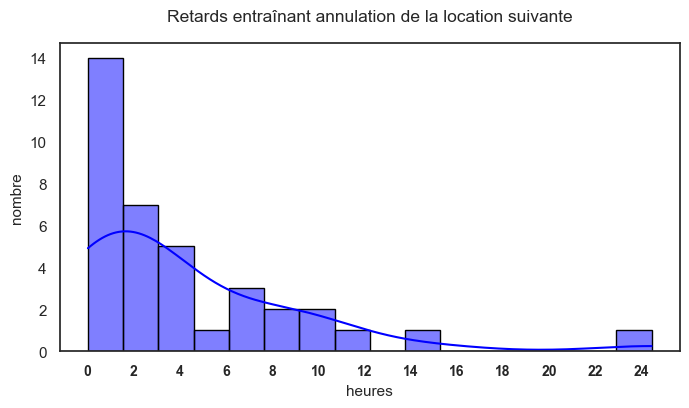

In [112]:
# Retards entraînant l'annulation de la location suivante 
impacting_delay = canceled_because_of_previous['previous_delay'].to_frame().reset_index()
sns.set(rc={"figure.figsize":(8, 4)}, style = 'white')
sns.histplot(data=impacting_delay, x='previous_delay', kde=True, bins=16, edgecolor='black', color='blue')
plt.ylabel('nombre', fontsize=11)
plt.xlabel('heures', fontsize=11)
plt.xticks([i for i in range (0,1460,120)], [i for i in range (0,25,2)], fontsize=10, fontweight='bold')
plt.title('Retards entraînant annulation de la location suivante', fontsize=12.5, pad=16)
plt.show()

Avec un seuil de 4h nous n'aurions plus que 12 clients mécontents, contre 37 au départ.

In [123]:
len(canceled_because_of_previous[canceled_because_of_previous['previous_delay'] > 240])

12

## Délai optimal entre 2 locations

Si on définit un délai de 12 heures entre deux locations :

- on éviterait d'avoir 40 clients mécontents ; 

- on éviterait 230 annulations liées à un délai trop serré ;

-  mais on perdrait 1840 réservations.


In [152]:
threshold = []
loss_rentals = []
cancellations = []

for i in range(0,721,30):
    loss = len(tight_rentals_enriched[(tight_rentals_enriched['time_gap']>=i)])
    cancellation = len(tight_rentals_enriched[(tight_rentals_enriched['canceled']==1) & (tight_rentals_enriched['time_gap']>=i)])
    threshold.append(i)
    loss_rentals.append(loss)
    cancellations.append(cancellation)

loss_and_gain = pd.DataFrame(list(zip(threshold,loss_rentals,cancellations)), columns=['threshold', 'total_rental', 'total_cancellation'])
loss_and_gain['threshold_hour'] = loss_and_gain['threshold']/60

In [153]:
loss_and_gain_df = loss_and_gain.copy()

In [154]:
loss_and_gain_df['delta_rental'] = 0
for i in range(1, len(loss_and_gain_df)):
    loss_count = loss_and_gain_df.iloc[i-1, 1] - loss_and_gain_df.iloc[i, 1] + loss_and_gain_df.iloc[i-1,4]
    loss_and_gain_df.iloc[i,4] = loss_count

In [155]:
loss_and_gain_df['delta_cancellation'] = 0
for i in range(1, len(loss_and_gain_df)):
    loss_count = loss_and_gain_df.iloc[i-1, 2] - loss_and_gain_df.iloc[i, 2] + loss_and_gain_df.iloc[i-1,5]
    loss_and_gain_df.iloc[i,5] = loss_count

In [156]:
loss_and_gain_df.rename(columns={'threshold_hour': 'seuil_en_heure', 
                                 'total_rental': 'reservations', 
                                 'total_cancellation': 'annulations', 
                                 'delta_rental': 'diminution_reservations',
                                 'delta_cancellation': 'diminution_annulations'},
                                 inplace = True)
loss_and_gain_df.head()

,threshold,reservations,annulations,seuil_en_heure,diminution_reservations,diminution_annulations
0,0,1841,229,0.0,0,0
1,30,1562,194,0.5,279,35
2,60,1440,186,1.0,401,43
3,90,1257,163,1.5,584,66
4,120,1175,155,2.0,666,74


In [30]:
loss_and_gain_df.to_csv('./src/data.csv',index=False)

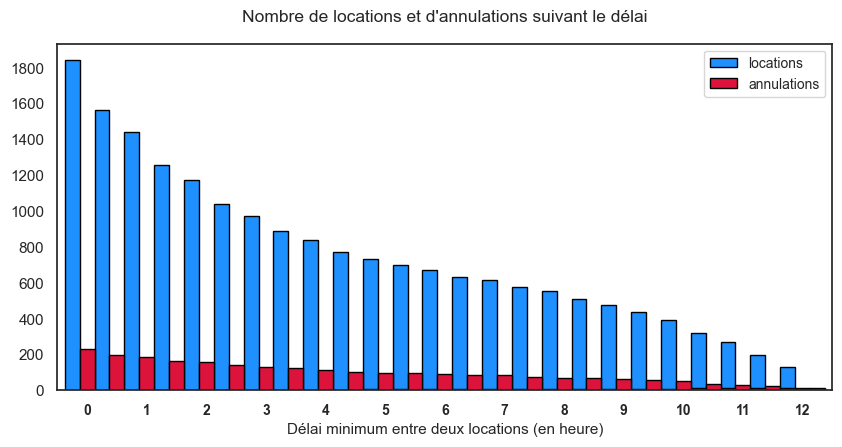

In [179]:
sns.set(rc={'figure.figsize':(10, 4.5)}, style='white')

loss_and_gain.set_index('threshold').plot(kind='bar', stacked=False, color=['dodgerblue', 'crimson'], width=1.5, edgecolor='black')

plt.title("Nombre de locations et d'annulations suivant le délai", fontsize=12.5, pad=16)
plt.ylabel('')
plt.xlabel('Délai minimum entre deux locations (en heure)', fontsize=11)
plt.yticks([i for i in range(0,1801,200)], [i for i in range(0,1801,200)], fontsize=11, fontweight='normal')
plt.xticks([i for i in range(0,25,2)], [i for i in range(0,13,1)], rotation=0, fontsize=10, fontweight='bold')
plt.legend(labels=['locations','annulations'], fontsize=10)
plt.show()

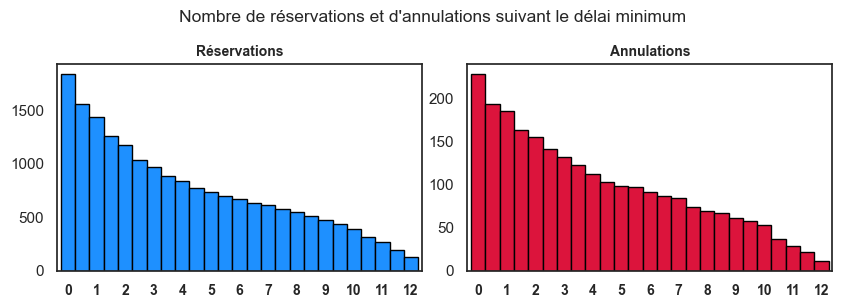

In [194]:
sns.set(rc={'figure.figsize':(10, 3)}, style='white')
fig, axes = plt.subplots(1, 2)
fig.subplots_adjust(hspace=0.125, wspace=0.125)
fig.suptitle("Nombre de réservations et d'annulations suivant le délai minimum", fontsize=12.5)
fig.subplots_adjust(top=.8)

loss_and_gain[['threshold_hour', 'total_rental']].set_index('threshold_hour').plot(kind='bar', stacked=False, color=['dodgerblue'], width=1, edgecolor='black', ax = axes[0])
loss_and_gain[['threshold_hour', 'total_cancellation']].set_index('threshold_hour').plot(kind='bar', stacked=False, color=['crimson'], width=1, edgecolor='black', ax = axes[1])

axes[0].set_title('Réservations', fontsize=10, fontweight='bold')
axes[1].set_title('Annulations', fontsize=10, fontweight='bold')

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[0].set_ylabel('count', fontsize=11)
axes[0].set_ylabel('')

axes[0].set_xticks([i for i in range(0,25,2)], [i for i in range(0,13,1)], rotation=0, fontsize = 10, fontweight='bold')
axes[1].set_xticks([i for i in range(0,25,2)], [i for i in range(0,13,1)], rotation=0, fontsize = 10, fontweight='bold')

axes[0].legend('', frameon=False)
axes[1].legend('', frameon=False)

plt.show()

## Part de revenus des locations serrées

On assume qu'une voiture représente un loueur. Nous ne traitons pas le cas où un loueur possède plusieurs voitures.

En moyenne les locations serrées représentent 28% des revenus des loueurs.

Pour certains loueurs cette part atteint plus de la moitié des revenus, le record étant de 80%.

Ces loueurs possèdent 1087 voitures soit 13.35% du parc total.

Avec cette flotte de 13.35% ils réalisent 34% des locations (tous types confondus), soit plus du tiers.

Ce groupe de loueurs est donc important pour Getaround.

In [430]:
all_rentals_df = df.groupby('car_id').count()['rental_id'].to_frame().reset_index()

In [431]:
tight_rentals = df.groupby('car_id').sum()['previous'].to_frame().reset_index()
tight_rentals_df = tight_rentals[tight_rentals['previous'] > 0].sort_values(by='previous', ascending=False)

tight_rentals_car_id = tight_rentals_df['car_id'].unique().tolist()
tight_rentals_count = df[df['car_id'].isin(tight_rentals_car_id)]['rental_id'].nunique()

tight_rentals_df.head()

,car_id,previous
2471,334190,15
612,241021,13
3844,365926,11
3977,368432,11
5640,392368,10


In [433]:
print('Voitures avec locations serrées :', tight_rentals_df['car_id'].nunique(), 'soit', round(tight_rentals_df['car_id'].nunique()/df['car_id'].nunique()*100,2), '% du parc total')
print('')
print('Total locations tous types confondus :', tight_rentals_count, 'soit', round(tight_rentals_count/len(df)*100,2), '% du toal')
print('')
print('Dont locations serrées :', tight_rentals_df['previous'].sum())

Voitures avec locations serrées : 1087 soit 13.35 % du parc total

Total locations tous types confondus : 7255 soit 34.05 % du toal

Dont locations serrées : 1841


In [434]:
owners_tight = pd.merge(tight_rentals_df, all_rentals_df, left_on='car_id', right_on='car_id')
owners_tight.rename(columns={'rental_id': 'total'}, inplace=True)
owners_tight['proportion'] = round(owners_tight['previous']/owners_tight['total']*100,2)

print('Part moyenne :', round(owners_tight['proportion'].mean(),2), '%')
print('Nombre de loueurs :', len(owners_tight))
owners_tight.sort_values(by='proportion', ascending=False).head(10)

Part moyenne : 27.48 %
Nombre de loueurs : 1087


,car_id,previous,total,proportion
68,368604,4,5,80.00
43,399575,5,7,71.43
207,383144,2,3,66.67
338,415726,2,3,66.67
327,226317,2,3,66.67
322,409088,2,3,66.67
313,307595,2,3,66.67
178,396552,2,3,66.67
311,310049,2,3,66.67
293,297119,2,3,66.67


## Impact sur les revenus

Nous fixons un seuil à 2h30 puis à 4h et nous observons l'impact sur les revenus.

### Seuil à 2h30

Le nombre de réservations descend à 1040 (contre 1840) : on perd 800 réservations.

Les loueurs concernés ne réalisent plus que 25% du revenu total (contre 34%).

Pour ces loueurs les locations serrées ne représentent en moyenne plus que 23% de leurs revenus (contre 28%).

In [435]:
cars_with_tight = df[df['car_id'].isin(tight_rentals_car_id)]
rentals_to_remove = cars_with_tight[(cars_with_tight['time_gap'] < 150) & (cars_with_tight['previous']== 1)]['rental_id'].to_list()
new_revenue = df[~df['rental_id'].isin(rentals_to_remove)]
print(len(new_revenue))
print(len(rentals_to_remove))

20506
803


In [440]:
tight_rentals = new_revenue.groupby('car_id').sum()['previous'].to_frame().reset_index()

tight_rentals_df = tight_rentals[tight_rentals['previous'] > 0].sort_values(by='previous', ascending=False)
tight_rentals_car_id = tight_rentals_df['car_id'].unique().tolist()
tight_rentals_count = df[df['car_id'].isin(tight_rentals_car_id)]['rental_id'].nunique()
tight_rentals_df.head()

,car_id,previous
3844,365926,9
2471,334190,7
5646,392479,7
3255,352528,7
4996,383110,7


In [442]:
print('Voitures avec locations serrées :', tight_rentals_df['car_id'].nunique(), 'soit', round(tight_rentals_df['car_id'].nunique()/df['car_id'].nunique()*100,2), '% du parc total')
print('')
print('Total locations tous types confondus :', tight_rentals_count, 'soit', round(tight_rentals_count/len(df)*100,2), '% du total')
print('')
print('Dont locations serrées :', tight_rentals_df['previous'].sum())

Voitures avec locations serrées : 717 soit 8.81 % du parc total

Total locations tous types confondus : 5337 soit 25.05 % du total

Dont locations serrées : 1038


In [407]:
owners_tight = pd.merge(tight_rentals_df, all_rentals_df, left_on='car_id', right_on='car_id')
owners_tight.rename(columns={'rental_id': 'total'}, inplace=True)
owners_tight['proportion'] = round(owners_tight['previous']/owners_tight['total']*100,2)

print('Part moyenne :', round(owners_tight['proportion'].mean(),2), '%')
print('Nombre de loueurs :', len(owners_tight))
owners_tight.sort_values(by='proportion', ascending=False).head(10)

Part moyenne : 22.73 %
Nombre de loueurs : 717


,car_id,previous,total,proportion
177,415726,2,3,66.67
64,223850,3,5,60.00
66,368604,3,5,60.00
30,310444,4,7,57.14
27,399575,4,7,57.14
242,415326,1,2,50.00
373,391153,1,2,50.00
364,408639,1,2,50.00
347,402153,1,2,50.00
314,398247,1,2,50.00


### Seuil à 4h soit 240 minutes

Le nombre de réservations descend à 840 (contre 1840) : on perd 1000 réservations.

Les loueurs concernés ne réalisent plus que 22% du revenu total (contre 34%).

Enfin pour ces loueurs les locations serrées ne représentent en moyenne plus que 21% de leurs revenus (contre 28%).

In [465]:
tight_rentals = df.groupby('car_id').sum()['previous'].to_frame().reset_index()
tight_rentals_df = tight_rentals[tight_rentals['previous'] > 0].sort_values(by='previous', ascending=False)
tight_rentals_car_id = tight_rentals_df['car_id'].unique().tolist()

In [466]:
cars_with_tight = df[df['car_id'].isin(tight_rentals_car_id)]
rentals_to_remove = cars_with_tight[(cars_with_tight['time_gap'] < 240) & (cars_with_tight['previous']== 1)]['rental_id'].to_list()
new_revenue = df[~df['rental_id'].isin(rentals_to_remove)]
print(len(new_revenue))
print(len(rentals_to_remove))

20308
1001


In [467]:
tight_rentals = new_revenue.groupby('car_id').sum()['previous'].to_frame().reset_index()
tight_rentals_df = tight_rentals[tight_rentals['previous'] > 0].sort_values(by='previous', ascending=False)

tight_rentals_car_id = tight_rentals_df['car_id'].unique().tolist()
tight_rentals_count = df[df['car_id'].isin(tight_rentals_car_id)]['rental_id'].nunique()

tight_rentals_df.head()

,car_id,previous
5646,392479,7
3844,365926,7
3255,352528,6
3977,368432,6
2471,334190,6


In [468]:
print('Voitures avec locations serrées :', tight_rentals_df['car_id'].nunique(), 'soit', round(tight_rentals_df['car_id'].nunique()/df['car_id'].nunique()*100,2), '% du parc total')
print('')
print('Total locations tous types confondus :', tight_rentals_count, 'soit', round(tight_rentals_count/len(df)*100,2), '% du total')
print('')
print('Dont locations serrées :', tight_rentals_df['previous'].sum())

Voitures avec locations serrées : 608 soit 7.47 % du parc total

Total locations tous types confondus : 4740 soit 22.24 % du total

Dont locations serrées : 840


In [469]:
owners_tight = pd.merge(tight_rentals_df, all_rentals_df, left_on='car_id', right_on='car_id')
owners_tight.rename(columns={'rental_id': 'total'}, inplace=True)
owners_tight['proportion'] = round(owners_tight['previous']/owners_tight['total']*100,2)

print('Part moyenne :', round(owners_tight['proportion'].mean(),2), '%')
print('Nombre de loueurs :', len(owners_tight))
owners_tight.sort_values(by='proportion', ascending=False).head(10)

Part moyenne : 21.37 %
Nombre de loueurs : 608


,car_id,previous,total,proportion
44,368604,3,5,60.0
367,301228,1,2,50.0
279,402153,1,2,50.0
308,408639,1,2,50.0
331,406994,1,2,50.0
483,367164,1,2,50.0
333,406995,1,2,50.0
362,303930,1,2,50.0
399,312157,1,2,50.0
397,320780,1,2,50.0


## Résultats

#### Annulations : 

- On observe que 88% des locations serrées sont maintenues. Seulement 12% sont annulées.

- Cela représente 229 locations annulées.

- Parmi elles, dans 106 cas sur 229 le précédent loueur était en retard. Pour plus de la moitié des cas, le loueur précédent n'était pas en retard.

- Parmi les retards, 37 dépassaient effectivement l'heure de début de la location suivante.

- Le temps de retour moyen étant de -38 minutes soit 38 minutes en avance.

- Lorsque le retard était impactant il était en moyenne de 250 minutes soit 4h10.

- On ignore si c'est le propriétaire ou le loueur qui est à l'origine de l'annulation.

#### Délai accordé : 

- Le délai moyen accordé pour les locations serrées se situe entre 4h30 et 5h.

- Il n'y a pas de différence notable lorsqu'elles sont annulées ou maintenues.

- En moyenne le loueur précédent a rendu la voiture dans un délai de -23 minutes soit 23 minutes en avance.

- Cependant dans 48% des cas, le loueur précédant une location serrée a rendu la voiture en retard. Ce taux est supérieur à la moyenne du groupe total (44%).

#### Méthode de check-in : 

- Les locations serrées sont davantages choisies avec la méthode connect que dans le groupe global : 44% contre 20%.

- Cela peut s'expliquer par le fait que cette méthode n'exige pas la validation du propriétaire. Le propriétaire est susceptible de refuser une location lorsqu'il estime le délai trop court, alors que la méthode connect n'applique pas de limitation dès lors que le véhicule est affiché comme disponible.

- Par ailleurs, les locations serrées réservées avec la méthode connect enregistrent plus d'annulations que celles réservées avec la méthode mobile : 57% contre 43%.

#### Revenus : 

- Les locations serrées représentent en moyenne 28% des revenus des loueurs concernés.

- Ces loueurs possèdent 13% du parc de voitures et réalisent 34% des locations totales.

- Ils représentent un groupe de loueurs importants pour Getaround.

#### Seuil : 

- Fixer un seuil à 2h30 permettrait de conserver 1000 réservations et les revenus des loueurs concernés seraient maintenus à 25%. Par ailleurs on réduit de moitié le nombre de clients mécontents.

- Augmenter le seuil à 4h permettrait de conserver 840 réservations et les revenus des loueurs concernés descendraient à 22%. Par ailleurs on réduit de deux tiers le nombre de clients mécontents.

- Au-delà de 5h les loueurs concernés représenteraient moins de 20% des revenus totaux.



